In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Besser als MinMax hier
from scipy import stats

In [2]:
# 1. Daten Laden
df = pd.read_csv('allData.csv')

# 2. WICHTIG: Vorfilterung der Ausreißer (Clean Data)
# Wir wollen Asteroidenfamilien finden, keine Kometen in der Oortschen Wolke.
# Behalten wir nur Objekte innerhalb von 10 AU (Jupiter ist bei 5.2)
df_clean = df[(df['a'] < 10) & (df['a'] > 1.0)].copy()

# Features auswählen
features = ['a', 'e', 'i']
X_original = df_clean[features].dropna()

/var/folders/tv/kwzyy9z51hl6kg2pqz9rjhz00000gn/T/ipykernel_3992/3464895518.py:2: DtypeWarning: Columns (17,23,24,25,36,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('allData.csv')


In [3]:
# 3. Skalieren (StandardScaler ist robuster gegen leichte Ausreißer als MinMax)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# 4. Clustering auf den SKALIERTEN Daten
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # k=4 ist oft gut für den Anfang
cluster_labels = kmeans.fit_predict(X_scaled)

# Die Labels an die ORIGINAL-Daten hängen zum Plotten
X_original['cluster'] = cluster_labels

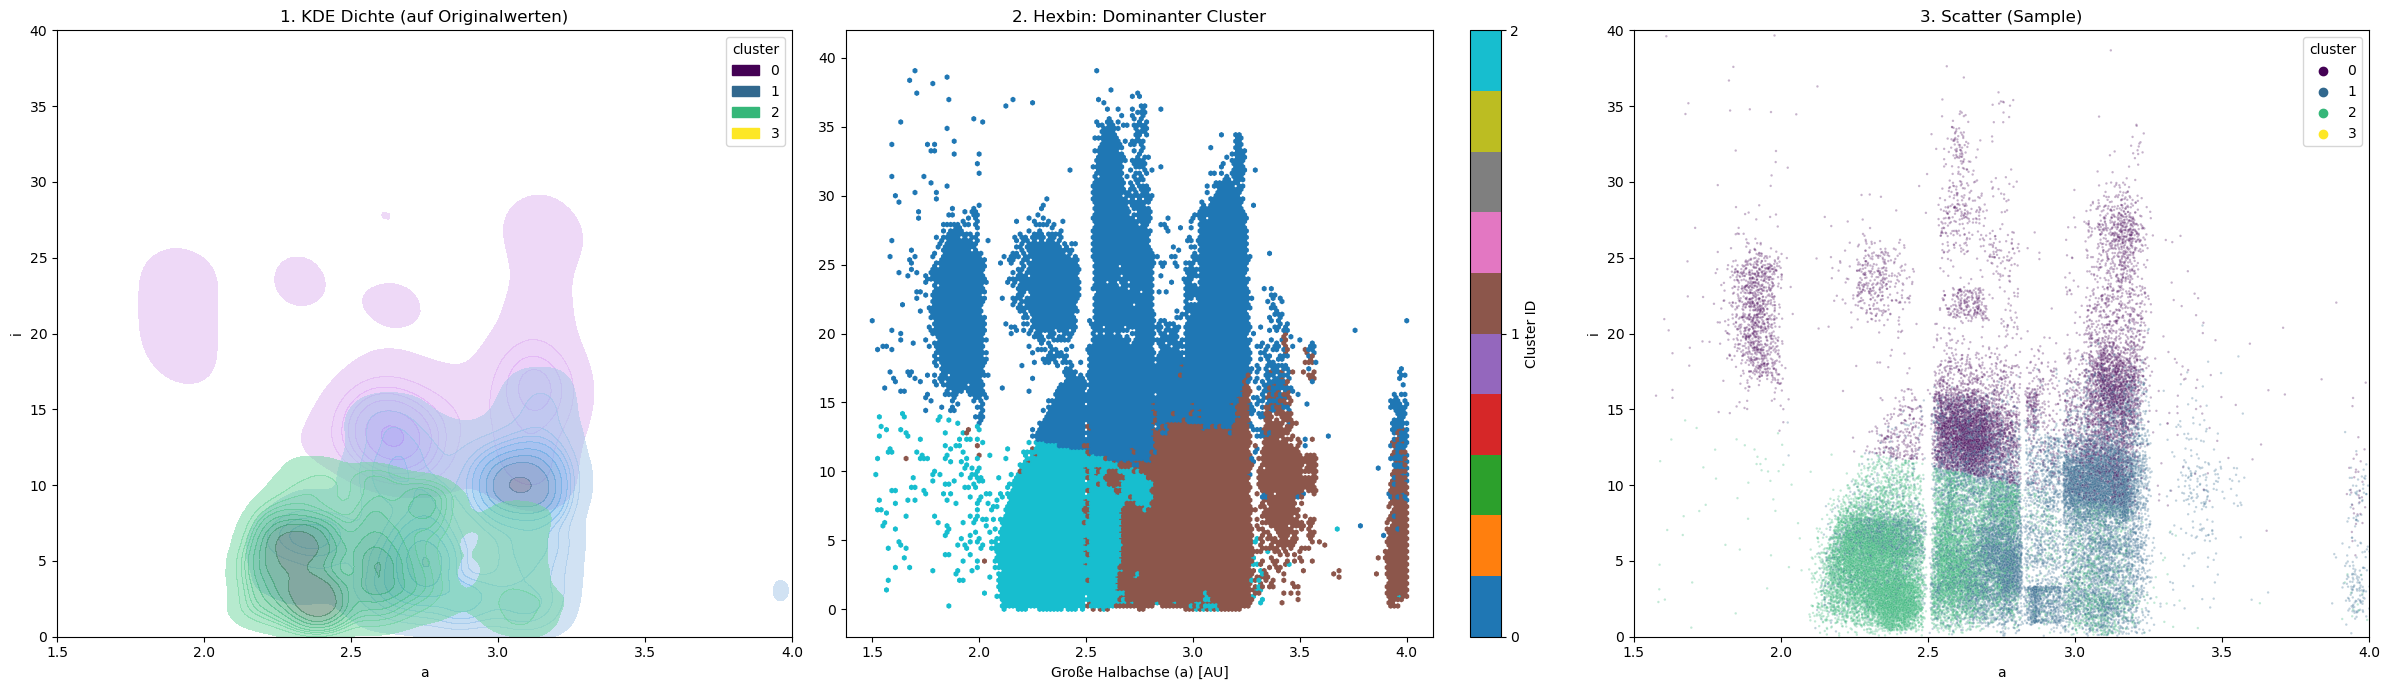

Cluster-Statistiken (Mittelwerte in echten Einheiten):
                a         e          i
cluster                               
0        2.739515  0.178743  16.898933
1        2.881428  0.081330   7.617207
2        2.469908  0.178478   4.881742
3        5.217393  0.081114  13.690117


In [4]:
# --- PLOTTING (Wir plotten X_original, NICHT X_scaled!) ---

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Sampling für Performance (Plotten dauert sonst ewig)
X_plot = X_original.sample(n=50000, random_state=42) if len(X_original) > 50000 else X_original

# --- PLOT 1: KDE (Dichte) ---
sns.kdeplot(
    data=X_plot, 
    x='a', y='i', 
    hue='cluster', 
    palette='viridis', 
    fill=True, 
    alpha=0.5, 
    levels=10, # Weniger Levels = schneller
    ax=axes[0]
)
axes[0].set_title('1. KDE Dichte (auf Originalwerten)')
axes[0].set_xlim(1.5, 4.0) # Jetzt machen diese Limits Sinn!
axes[0].set_ylim(0, 40)

# --- PLOT 2: Hexbin ---
def get_dominant_cluster(x):
    if len(x) == 0: return np.nan
    # Modus berechnen (Cluster der am häufigsten in der Wabe vorkommt)
    return stats.mode(x, keepdims=False)[0]

# Hier nutzen wir das ganze Dataset (X_original), Hexbin ist schnell!
hb = axes[1].hexbin(
    X_original['a'], X_original['i'], 
    C=X_original['cluster'],    
    reduce_C_function=get_dominant_cluster, 
    gridsize=150, 
    cmap='tab10',       
    mincnt=1,
    extent=[1.5, 4.0, 0, 40] # Setzt Limits direkt im Hexbin
)
axes[1].set_title('2. Hexbin: Dominanter Cluster')
axes[1].set_xlabel('Große Halbachse (a) [AU]')
cb = plt.colorbar(hb, ax=axes[1], ticks=range(4))
cb.set_label('Cluster ID')

# --- PLOT 3: Scatter (Physikalisch) ---
sns.scatterplot(
    data=X_plot, 
    x='a', y='i', 
    hue='cluster', 
    palette='viridis', 
    s=3, 
    alpha=0.3, 
    ax=axes[2], 
    legend='full'
)
axes[2].set_title('3. Scatter (Sample)')
axes[2].set_xlim(1.5, 4.0)
axes[2].set_ylim(0, 40)

plt.tight_layout()
plt.show()

# Statistik prüfen (sollte jetzt echte Werte in AU zeigen)
print("Cluster-Statistiken (Mittelwerte in echten Einheiten):")
print(X_original.groupby('cluster')[['a', 'e', 'i']].mean())